In [36]:
import json

competition_name = 'ligue-1'
shots_filename = competition_name+'-shots.json'
assists_filename = competition_name+'-assists.json'
output_filename = competition_name+'.json'

with open(shots_filename, 'r', encoding='utf-8') as f:
    all_shots = json.load(f)

with open(assists_filename, 'r', encoding='utf-8') as f:
    all_assists = json.load(f)

In [37]:
shot_index = 1035
shot_event = all_shots[shot_index]

print('shot_event')
print()
print(shot_event.keys())

shot_event

dict_keys(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'player', 'position', 'location', 'duration', 'related_events', 'shot'])


In [38]:
shot_data = shot_event['shot']

print('shot_data')
print()
print(shot_data.keys())

shot_data

dict_keys(['statsbomb_xg', 'end_location', 'key_pass_id', 'type', 'outcome', 'technique', 'body_part', 'freeze_frame'])


In [39]:
if 'freeze_frame' in shot_data:
    freeze_frame = shot_data['freeze_frame']
    print('freeze_frame')
    print()
    print('Array of these...')
    print(freeze_frame[0].keys())
else:
    freeze_frame = None
    print('no freeze_frame')

freeze_frame

Array of these...
dict_keys(['location', 'player', 'position', 'teammate'])


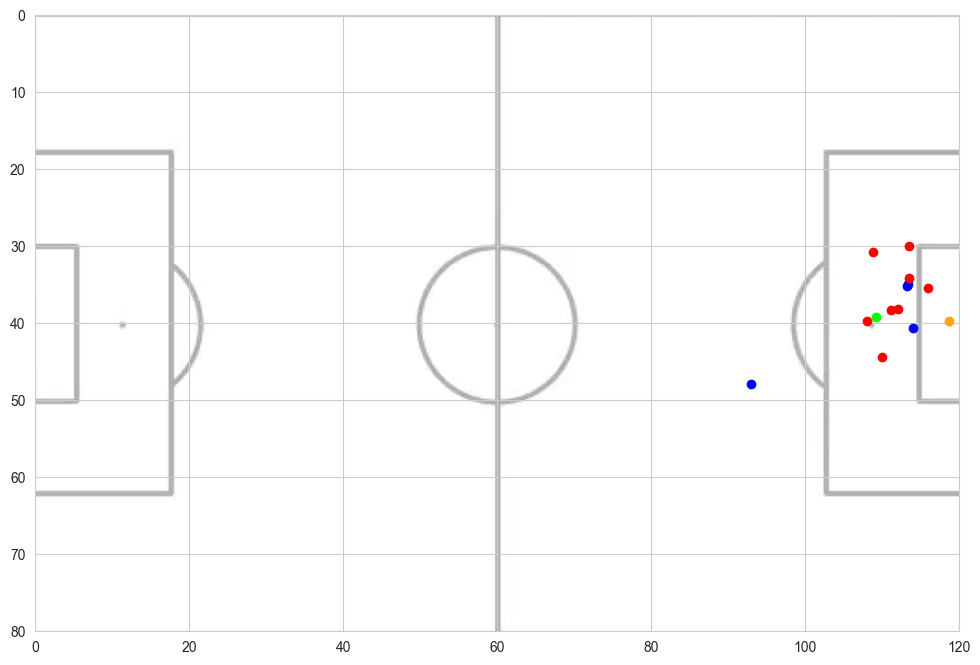

In [40]:
# print out a graph of all of the positions the players are in, colour coded by team (special colours for kicker and keeper)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def print_shot(shot_event, freeze_frame=None):

    shot_location = shot_event['location']
    team_locations = []
    op_locations = []
    keeper_location = []

    if freeze_frame is not None:
        for player in freeze_frame:
            if player['teammate']:
                team_locations.append(player['location'])
            else:
                if player['position']['id'] == 1:
                    keeper_location = player['location']
                else:
                    op_locations.append(player['location'])
    else:
        keeper_location = [120,40]

    pitch_image = mpimg.imread('pitch.png')

    # Extracting x and y coordinates for each team
    shot_x, shot_y = [shot_location[0]], [shot_location[1]]
    keeper_x, keeper_y = [keeper_location[0]], [keeper_location[1]]

    team_x, team_y = [team_location[0] for team_location in team_locations],[team_location[1] for team_location in team_locations]
    op_x, op_y = [op_location[0] for op_location in op_locations],[op_location[1] for op_location in op_locations]

    # Creating the plot
    plt.figure(figsize=(12, 8))
    plt.imshow(pitch_image, extent=(0., 120., 0., 80.))

    # Plotting shot location
    plt.scatter(shot_x, shot_y, color='lime', label='Shot')
    # Plotting keeper location
    plt.scatter(keeper_x, keeper_y, color='orange', label='GK')
    # Plotting team locations
    plt.scatter(team_x, team_y, color='blue', label='Team')
    # Plotting opponent locations
    plt.scatter(op_x, op_y, color='red', label='Opponents')

    # Setting the x and y limits
    plt.xlim(0, 120)
    plt.ylim(0, 80)

    plt.gca().invert_yaxis()

    # Display the plot
    plt.show()

print_shot(shot_event, freeze_frame)


In [41]:
# Cross data
# Dictionary of {shot_id: 'Ground Pass'}

assist_lookup = {}

total_assists = len(all_assists)-1
for index, assist_event in enumerate(all_assists):
    assist_lookup[assist_event['pass']['assisted_shot_id']] = assist_event['pass']['height']['name']

# for index, (key, value) in enumerate(assist_lookup.items()):
#     print(key, value)
#     if index > 50:
#         break


In [42]:
# How many opposing players are nearby
# GK position (in position... if they're in the angle)

import numpy as np

final_shots = []

left_goalpost = np.array([120,36])
right_goalpost = np.array([120,44])
goal_center = np.array([120,40])

def points_in_triangle(points, a, b, c):
    area_abc = 0.5 * np.abs(
        a[0] * (b[1] - c[1]) +
        b[0] * (c[1] - a[1]) +
        c[0] * (a[1] - b[1])
    )

    area_abd = 0.5 * np.abs(
        a[0] * (b[1] - points[:, 1]) +
        b[0] * (points[:, 1] - a[1]) +
        points[:, 0] * (a[1] - b[1])
    )

    area_bcd = 0.5 * np.abs(
        b[0] * (c[1] - points[:, 1]) +
        c[0] * (points[:, 1] - b[1]) +
        points[:, 0] * (b[1] - c[1])
    )

    area_cad = 0.5 * np.abs(
        c[0] * (a[1] - points[:, 1]) +
        a[0] * (points[:, 1] - c[1]) +
        points[:, 0] * (c[1] - a[1])
    )

    in_triangle = np.isclose(area_abc, area_abd + area_bcd + area_cad)
    return np.sum(in_triangle)

def angle_abc(a, b, c):
    # Cosine rule to find angle
    BA = a - b
    BC = c - b
    dot_product = np.dot(BA, BC)
    magnitude_BA = np.linalg.norm(BA)
    magnitude_BC = np.linalg.norm(BC)
    cos_theta = dot_product / (magnitude_BA * magnitude_BC)
    return np.arccos(cos_theta)

attacking_positions = ['Right Wing', 'Right Attacking Midfield', 'Center Attacking Midfield', 'Left Attacking Midfield', 'Left Wing', 'Right Center Forward', 'Striker', 'Left Center Forward', 'Secondary Striker']

total_shots = len(all_shots)-1
for index, shot_event in enumerate(all_shots):

    final_shot = {}
    print(index,'/',total_shots)

    # Important shot_event data
    final_shot['index'] = index
    final_shot['id'] = shot_event['id']
    final_shot['team'] = shot_event['team']['name']
    final_shot['player'] = shot_event['player']['name']

    if 'shot' not in shot_event:
        print('No shot data for',index)
        continue

    shot_data = shot_event['shot']

    team_locations = np.empty((0, 2))
    op_locations = np.empty((0, 2))
    # will be a np array with 1 value ...
    keeper_location = np.empty((0, 2))

    if 'freeze_frame' not in shot_data:
        # Setup data to be penalty data
        player_location = np.array([119.9,40])

        keeper_location = np.vstack([keeper_location, player_location])
        op_locations = np.vstack([op_locations, player_location])
        shot_location = np.array([108,40])

    else:
        freeze_frame = shot_data['freeze_frame']
        shot_location = np.array(shot_event['location'])

        for player in freeze_frame:

            player_location = np.array(player['location'])

            if player['teammate']:
                team_locations = np.vstack([team_locations,player_location])
            else:
                # Different to the plot above, keeper is included in ops
                if player['position']['id'] == 1:
                    keeper_location = np.vstack([keeper_location, player_location])

                op_locations = np.vstack([op_locations,player_location])

    final_shot['statsbomb_xg'] = shot_data['statsbomb_xg']

    # Distance
    final_shot['distance'] = float(np.linalg.norm(shot_location - goal_center))

    # Angle to goal
    final_shot['angle'] = float(angle_abc(left_goalpost, shot_location, right_goalpost))

    # Is the keeper in the angle?
    final_shot['keeper_in_position'] = int(points_in_triangle(keeper_location,left_goalpost,shot_location,right_goalpost))

    # how many bodies in the way?
    final_shot['blocking_bodies'] = int(points_in_triangle(op_locations,left_goalpost,shot_location,right_goalpost))

    # Number of surrounding players (2 yards)
    op_distances = np.linalg.norm(op_locations - shot_location, axis=1)
    final_shot['pressuring_players'] = int(np.sum(op_distances <= 2))

    # Player is a winger/striker/attacking mid
    final_shot['attacking_position'] = 1 if shot_event['position']['name'] in attacking_positions else 0

    # These only appear in the data if they're true
    # final_shot['first_time'] = 1 if 'first_time' in shot_data else 0
    # final_shot['under_pressure'] = 1 if 'under_pressure' in shot_data else 0

    final_shot['assist_ground'] = 0
    final_shot['assist_low'] = 0
    final_shot['assist_high'] = 0

    if shot_event['id'] in assist_lookup:
        final_shot['assist_ground'] = 1 if assist_lookup[shot_event['id']] == 'Ground Pass' else 0
        final_shot['assist_low'] = 1 if assist_lookup[shot_event['id']] == 'Low Pass' else 0
        final_shot['assist_high'] = 1 if assist_lookup[shot_event['id']] == 'High Pass' else 0

    # corner, kickoff, openplay fall into both off to avoid dvt
    final_shot['penalty'] = 1 if shot_data['type']['name'] == 'Penalty' else 0
    final_shot['freekick'] = 1 if shot_data['type']['name'] == 'Free Kick' else 0

    #  Normal', 'Lob' fall into all off to avoid dvt
    final_shot['technique_other'] = 1 if shot_data['technique']['name'] in ['Overhead Kick', 'Backheel', 'Diving Header'] else 0
    final_shot['technique_halfvolley'] = 1 if shot_data['technique']['name'] == 'Half Volley' else 0
    final_shot['technique_volley'] = 1 if shot_data['technique']['name'] == 'Volley' else 0

    # Right foot is all off to avoid dvt
    final_shot['foot'] = 1 if shot_data['body_part']['name'] in ['Left Foot','Right Foot'] else 0

    # OUTCOME
    final_shot['goal'] = 1 if shot_data['outcome']['name'] == 'Goal' else 0

    # print(index)
    # for key,value in final_shot.items():
    #     print(key, value)
    # print()

    final_shots.append(final_shot)

# Output all CL shots to a json file
with open(output_filename, 'w', encoding='utf-8') as file:
    json.dump(final_shots,file,indent=4,ensure_ascii=False)


0 / 8813
1 / 8813
2 / 8813
3 / 8813
4 / 8813
5 / 8813
6 / 8813
7 / 8813
8 / 8813
9 / 8813
10 / 8813
11 / 8813
12 / 8813
13 / 8813
14 / 8813
15 / 8813
16 / 8813
17 / 8813
18 / 8813
19 / 8813
20 / 8813
21 / 8813
22 / 8813
23 / 8813
24 / 8813
25 / 8813
26 / 8813
27 / 8813
28 / 8813
29 / 8813
30 / 8813
31 / 8813
32 / 8813
33 / 8813
34 / 8813
35 / 8813
36 / 8813
37 / 8813
38 / 8813
39 / 8813
40 / 8813
41 / 8813
42 / 8813
43 / 8813
44 / 8813
45 / 8813
46 / 8813
47 / 8813
48 / 8813
49 / 8813
50 / 8813
51 / 8813
52 / 8813
53 / 8813
54 / 8813
55 / 8813
56 / 8813
57 / 8813
58 / 8813
59 / 8813
60 / 8813
61 / 8813
62 / 8813
63 / 8813
64 / 8813
65 / 8813
66 / 8813
67 / 8813
68 / 8813
69 / 8813
70 / 8813
71 / 8813
72 / 8813
73 / 8813
74 / 8813
75 / 8813
76 / 8813
77 / 8813
78 / 8813
79 / 8813
80 / 8813
81 / 8813
82 / 8813
83 / 8813
84 / 8813
85 / 8813
86 / 8813
87 / 8813
88 / 8813
89 / 8813
90 / 8813
91 / 8813
92 / 8813
93 / 8813
94 / 8813
95 / 8813
96 / 8813
97 / 8813
98 / 8813
99 / 8813
100 / 8813